# Dataset overview

In [1]:
import sys
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
#nltk.download('stopwords')
#nltk.download('punkt')
import warnings
warnings.filterwarnings('ignore')

## Read the dataset
The dataset contains the columns ['time_created'、'date_created'、'up_votes'、'down_votes'、'title'、'over_18'、'author' and 'category'].  The ['down_votes'] and ['category'] can be droped at first because they are all "0" and all "worldnews". 

The first task is to get some analytical insights. We can determine the popular authors based on the up_votes they received, which would be useful for the company to put more emphanize these 'VIP' authors and their reports.

The second task is to perform predictive modeling. For instance, if the 'title' only can be used to tell us more information, such as if the author is over 18 or not, or if the news would receive high votes, etc.

In [2]:
worldnews = pd.read_csv("Eluvio_DS_Challenge.csv")
worldnews.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


In [3]:
worldnews.shape
#worldnews.info()

(509236, 8)

In [4]:
worldnews.iloc[:, 4:7].describe()

,title,over_18,author
count,509236,509236,509236
unique,500720,2,85838
top,Brutality of Syrian Rebels Posing Dilemma in West,False,davidreiss666
freq,6,508916,8897


In [5]:
worldnews.over_18.value_counts()

worldnews['length'] = worldnews['title'].apply(len)
print(f"Maximum length of title is {max(worldnews['length'])}")
print(f"Minimim length of title is {min(worldnews['length'])}")

Maximum length of title is 320
Minimim length of title is 1


# Popularity analysis

## Find popular words in titles 

In [6]:
#%% data cleaning and tokenize
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
stopwords = set(stopwords.words('english'))

best_titles = worldnews.sort_values(by='up_votes',
                                    ascending=False)['title'].values[:10]
best_words = set(np.concatenate([word_tokenize(t)
                                 for t in best_titles])) - stopwords
best_words = {word.lower() for word in best_words}
best_words = best_words - set(string.punctuation) - set(string.digits)

words_tokenized = [[w.lower() for w in word_tokenize(t)]
                   for t in worldnews['title']]
all_words = pd.Series(np.concatenate(words_tokenized)).value_counts()
all_words = all_words[[word not in stopwords for word in all_words.index]]
all_words = all_words[[
    word not in string.punctuation for word in all_words.index
]]
all_words = all_words[[word not in string.digits for word in all_words.index]]
all_words = all_words[["'" not in word for word in all_words.index]]
all_words = all_words[['’' not in word for word in all_words.index]]
all_words[0:10].index

Index(['china', 'says', 'us', 'new', 'syria', 'russia', 'world', 'police',
       'iran', 'israel'],
      dtype='object')

The most frequent 10 words are: ['say', 'kill', 'china', 'us', 'new', 'attack', 'syria', 'russia', 'world', 'polic']


Text(0, 0.5, 'counts')

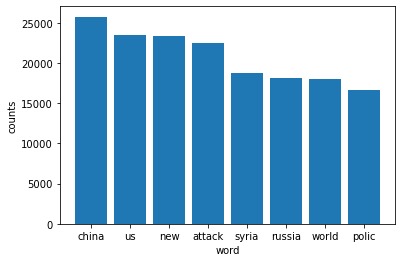

In [26]:
#%% Stemmer
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
all_words.index = [stemmer.stem(w) for w in all_words.index]
all_stems = all_words.groupby(by=all_words.index).sum().sort_values(
    ascending=False)
print('The most frequent 10 words are:', all_stems.index.tolist()[0:10])
plt.bar(all_stems.index[2:10],all_stems[2:10])
plt.xlabel('word')
plt.ylabel('counts')

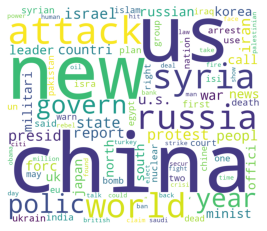

In [27]:
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white",width=1000, height=860, margin=2).generate_from_frequencies(dict(all_stems[2:100]))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Active & popular 'VIP' authors

In [8]:
#%% 
authors = worldnews['author']
upvotes = worldnews['up_votes']
all_authors = authors.value_counts()
all_authors = pd.DataFrame(all_authors)
print('The first 10 active authors with most reports are:', all_authors.index.tolist()[0:3],'et al.')

pop_authors = worldnews[['author','up_votes']]
pop_authors1 = pop_authors.groupby(by=pop_authors.author).sum().sort_values(by='up_votes', ascending=False)
print('The first 10 popular authors with most up votes are:', pop_authors1.index.tolist()[0:3],'et al.')

The first 10 active authors with most reports are: ['davidreiss666', 'anutensil', 'DoremusJessup'] et al.
The first 10 popular authors with most up votes are: ['maxwellhill', 'anutensil', 'Libertatea'] et al.


Text(0.5, 1.0, 'active as well as popular authors')

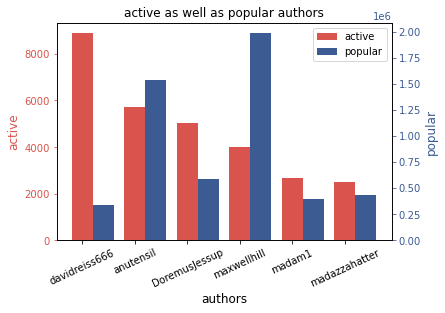

In [9]:
a = all_authors.index[0:10]
b = pop_authors1.index[0:10]
aa= a & b
fig, ax1 = plt.subplots()
width = 0.4
x1_list = []
x2_list = []
for i in range(len(aa)):
    x1_list.append(i)
    x2_list.append(i + width)
p1 = ax1.bar(x1_list, [all_authors.loc[i][0] for i in aa],width=width,color = sns.xkcd_rgb["pale red"], tick_label =[i for i in aa], label='active')
ax2 = ax1.twinx()
p2 = ax2.bar(x2_list, [pop_authors1.loc[i][0] for i in aa],width=width, color = sns.xkcd_rgb["denim blue"], label='popular')
ax1.set_xlabel('authors',fontsize=12)
ax1.set_ylabel('active',fontsize=12)
ax2.set_ylabel('popular',fontsize=12)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 25)
# 
ax1.yaxis.label.set_color(p1[0].get_facecolor())
ax2.yaxis.label.set_color(p2[0].get_facecolor())
# 
ax1.tick_params(axis = 'y', colors = p1[0].get_facecolor())
ax2.tick_params(axis = 'y', colors = p2[0].get_facecolor())
plt.legend(handles = [p1,p2])
plt.title('active as well as popular authors')

# Predictions

## Prediction on over 18 or not

From the title length, it is hard to say there are significant difference between authors over 18 or not


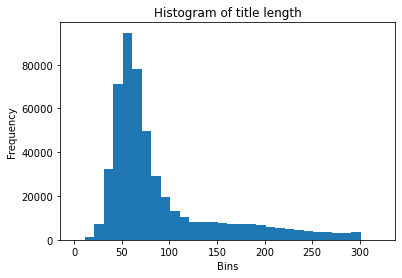

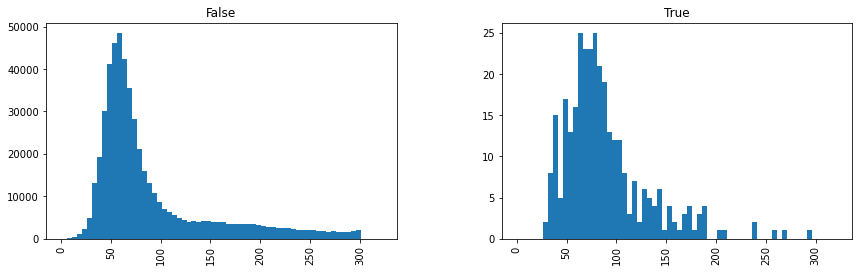

In [10]:
data = list(worldnews['length'])
binsize = 10
plt.hist(data, bins=range(min(data), max(data) + binsize, binsize))
plt.title('Histogram of title length')
plt.xlabel("Bins")
plt.ylabel("Frequency")

binsize = 5
worldnews.hist(column='length',
               by='over_18',
               bins=range(min(data),
                          max(data) + binsize, binsize),
               figsize=(14, 4))

print('From the title length, it is hard to say there are significant difference between authors over 18 or not')

In [11]:
#%% predictionn
worldnews.loc[:, 'over_18'] = worldnews.over_18.map({False: 0, True: 1})
from sklearn.model_selection import train_test_split
X = worldnews['title']

##
Y = worldnews['over_18']
##
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    Y,
                                                    test_size=0.20,
                                                    random_state=1,
                                                    stratify=Y)

In [12]:
# tf-idf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(min_df =10**-3 ,analyzer = 'word',  ngram_range=(1,3))
# Fit the training data and then return the matrix
training_data = tfidf_vectorizer.fit_transform(X_train)#！
# Transform testing data and return the matrix. 
testing_data = tfidf_vectorizer.transform(X_test)

In [13]:
#%%
from sklearn.naive_bayes import MultinomialNB
naive_bayes = MultinomialNB()
naive_bayes.fit(training_data,y_train) 
#Make prediction on test dataset
y_predict = naive_bayes.predict(testing_data)
nb_sco = naive_bayes.score(testing_data, y_predict)

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
print('Accuracy score: {}'.format(accuracy_score(y_test, y_predict)))
print('Precision score: {}'.format(precision_score(y_test, y_predict)))
print('Recall score: {}'.format(recall_score(y_test, y_predict)))
print('F1 score: {}'.format(f1_score(y_test, y_predict)))
print('Althrough the accuracy is high, the precision and recall are all 0. So the classification on over 18 or not cannot be predicted by the title contents.')

Accuracy score: 0.9993716125991674
Precision score: 0.0
Recall score: 0.0
F1 score: 0.0
Althrough the accuracy is high, the precision and recall are all 0. So the classification on over 18 or not cannot be predicted by the title contents.


## Prediction on high popularity or not

In [15]:
#%% predictionn
worldnews.loc[:, 'over_18'] = worldnews.over_18.map({False: 0, True: 1})
print(worldnews.shape)
from sklearn.model_selection import train_test_split
X = worldnews['title']

##
thre = np.quantile(worldnews['up_votes'], 0.8)
y = [1 if i > thre else 0 for i in worldnews['up_votes']]
pd.value_counts(y)
Y = np.array(y)
##

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    Y,
                                                    test_size=0.20,
                                                    random_state=1,
                                                    stratify=Y)

(509236, 9)


In [16]:
# tf-idf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(min_df =10**-3 ,analyzer = 'word',  ngram_range=(1,3))
# Fit the training data and then return the matrix
training_data = tfidf_vectorizer.fit_transform(X_train)#！
# Transform testing data and return the matrix. 
testing_data = tfidf_vectorizer.transform(X_test)

### Naive_bayes classifier

In [17]:
#%%
from sklearn.naive_bayes import MultinomialNB
naive_bayes = MultinomialNB()
naive_bayes.fit(training_data,y_train) 
#Make prediction on test dataset
y_predict = naive_bayes.predict(testing_data)
nb_sco = naive_bayes.score(testing_data, y_predict)

Accuracy score: 0.8046304296598853
Precision score: 0.5113636363636364
Recall score: 0.0022613065326633165
F1 score: 0.004502701620972584
              precision    recall  f1-score   support

           0       0.80      1.00      0.89     81948
           1       0.51      0.00      0.00     19900

    accuracy                           0.80    101848
   macro avg       0.66      0.50      0.45    101848
weighted avg       0.75      0.80      0.72    101848



<AxesSubplot:>

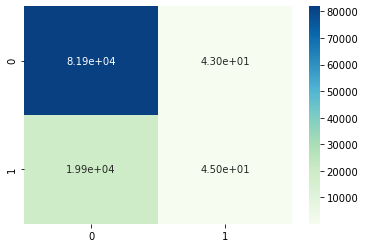

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
nb_acc=accuracy_score(y_test, y_predict)
print('Accuracy score: {}'.format(accuracy_score(y_test, y_predict)))
print('Precision score: {}'.format(precision_score(y_test, y_predict)))
print('Recall score: {}'.format(recall_score(y_test, y_predict)))
print('F1 score: {}'.format(f1_score(y_test, y_predict)))
print(classification_report(y_test, y_predict))
cm=confusion_matrix(y_test, y_predict)
tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel() #x label is pred, 0, 1

sns.heatmap(cm, annot = True, fmt = '.2e',cmap = 'GnBu')

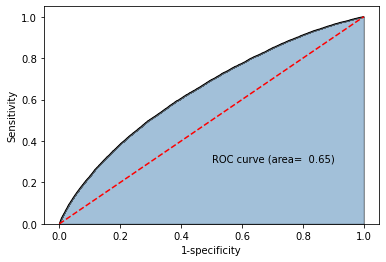

In [19]:
from sklearn import metrics
y_score = naive_bayes.predict_proba(testing_data)[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_score)
roc_auc = metrics.auc(fpr, tpr)
plt.stackplot(fpr, tpr, color='steelblue', alpha=0.5, edgecolor='black')
plt.plot(fpr, tpr, color='black', lw=1)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.text(0.5, 0.3, 'ROC curve (area= % 0.2f)' % roc_auc)
plt.xlabel('1-specificity')
plt.ylabel('Sensitivity')
plt.show()

### RandomForest classifier

In [20]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_jobs = -1, max_features = 'sqrt', n_estimators = 10, oob_score = True)
rfc.fit(training_data, y_train)
y_predict = rfc.predict(testing_data)
rf_sco = rfc.score(testing_data, y_predict)
print(classification_report(y_test, y_predict))
rf_acc=accuracy_score(y_test, y_predict)
print('Accuracy score: {}'.format(accuracy_score(y_test, y_predict)))

              precision    recall  f1-score   support

           0       0.81      0.98      0.89     81948
           1       0.29      0.03      0.06     19900

    accuracy                           0.80    101848
   macro avg       0.55      0.51      0.47    101848
weighted avg       0.70      0.80      0.72    101848

Accuracy score: 0.7954893566883984


### LogisticRegression classifier

In [21]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(C=1.0, penalty='l2', tol=0.01)
LR.fit(training_data, y_train)
y_predict = LR.predict(testing_data)
LR.score(testing_data, y_predict)
print(classification_report(y_test, y_predict))
lr_acc=accuracy_score(y_test, y_predict)
print('Accuracy score: {}'.format(accuracy_score(y_test, y_predict)))

              precision    recall  f1-score   support

           0       0.81      0.99      0.89     81948
           1       0.51      0.04      0.08     19900

    accuracy                           0.81    101848
   macro avg       0.66      0.52      0.49    101848
weighted avg       0.75      0.81      0.73    101848

Accuracy score: 0.8050428088916817


[Text(0, 0, 'Naive Bayes'),
 Text(0, 1, 'Random Forest'),
 Text(0, 2, 'Logistic Regression')]

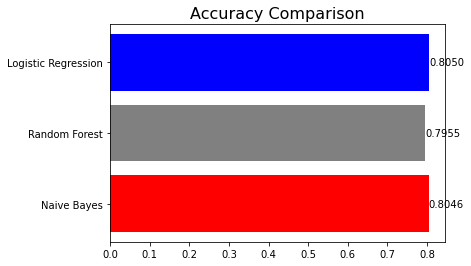

In [24]:
data = [nb_acc,rf_acc,lr_acc]
clf=['Naive Bayes','Random Forest','Logistic Regression']
colors = ['red' , 'gray','blue']

fig, ax = plt.subplots()
b=plt.barh(range(len(data)),data, tick_label=clf, color=colors)
for rect in b:
    w = rect.get_width()
    ax.text(w, rect.get_y()+rect.get_height()/2, '%0.4f' %
            w, ha='left', va='center')
plt.title('Accuracy Comparison', loc='center', fontsize='16')
ax.set_yticks(range(len(clf)))
ax.set_yticklabels(clf)

